In [1]:
# !pip install torch pandas numpy torchinfo pickle-mixin tqdm matplotlib scikit-learn wandb
# !pip install "numpy<2"

In [2]:
import wandb
import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
import sys
import pandas as pd
import pickle
import numpy as np
from tqdm import tqdm
from datetime import datetime
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gothchico. Use `wandb login --relogin` to force relogin


True

In [4]:
import platform; print(platform.platform())

macOS-14.6.1-arm64-arm-64bit


In [5]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    # print(X.shape,T,N,Y.shape)
    df = np.array(X)
    print(df.shape)
    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [6]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [7]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [8]:
device = mps_device

In [9]:
x.type()

'torch.mps.FloatTensor'

In [10]:
# please change the data_path to your local path
# data_path = '/nfs/home/zihaoz/limit_order_book/data'

dec_data = np.loadtxt('../data/data/Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('../data/data/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('../data/data/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('../data/data/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 203800) (149, 50950) (149, 139587)


In [11]:
sys.getsizeof(dec_data)/1000000

303.662128

In [12]:
batch_size = 64

dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

(203800, 40)
(50950, 40)
(139587, 40)
torch.Size([203701, 1, 100, 40]) torch.Size([203701])


In [13]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[0.1276, 0.0216, 0.1274,  ..., 0.0261, 0.1265, 0.0120],
          [0.1276, 0.0216, 0.1274,  ..., 0.0261, 0.1265, 0.0120],
          [0.1276, 0.0216, 0.1274,  ..., 0.0261, 0.1265, 0.0120],
          ...,
          [0.1271, 0.0020, 0.1270,  ..., 0.0552, 0.1261, 0.0040],
          [0.1271, 0.0005, 0.1270,  ..., 0.0492, 0.1261, 0.0040],
          [0.1271, 0.0005, 0.1270,  ..., 0.0492, 0.1261, 0.0040]]]],
       dtype=torch.float64)
tensor([2.], dtype=torch.float64)
torch.Size([1, 1, 100, 40]) torch.Size([1])


In [14]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

In [15]:
model = deeplob(y_len = dataset_train.num_classes)
model.to(mps_device)
device = mps_device

In [16]:
EPOCHS = 50
lr=0.0001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
state_dict = None

In [17]:
run = wandb.init(
    project="fast-alpha",
    config={
        "learning_rate": lr,
        "epochs": EPOCHS,
        "batch_size": batch_size
    },
)

In [18]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    global state_dict
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        all_targets = []
        all_predictions = []

        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
             
            _, predictions = torch.max(outputs, 1)
            
            # print(f"targets: {targets.shape}")
            # print(f"targets: {targets}")
            # print(f"predictions: {predictions.shape}") 
            # print(f"predictions: {predictions}") 
            all_targets.append(targets.cpu().numpy())           
            all_predictions.append(predictions.cpu().numpy())


        all_targets = np.concatenate(all_targets)    
        all_predictions = np.concatenate(all_predictions)   
        test_loss = np.mean(test_loss)

        precision = precision_score(all_targets, all_predictions, average='weighted')
        recall = recall_score(all_targets, all_predictions, average='weighted')
        f1 = f1_score(all_targets, all_predictions, average='weighted')

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            # state_dict = copy.deepcopy(model.state_dict())
            torch.save(model, '../runs/my_best_val_model_pytorch')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(dt)
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')
        wandb.log({"accuracy": accuracy_score(all_targets, all_predictions), "train_loss": train_loss, "val_loss": test_loss, "epoch_time(seconds)": dt.total_seconds()})
        wandb.log({"precision": precision, "sensitivity": recall, "f1-score" : f1})
    return train_losses, test_losses

In [19]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=EPOCHS)

  2%|█▋                                                                                 | 1/50 [03:13<2:37:58, 193.43s/it]

model saved
0:03:13.427877
Epoch 1/50, Train Loss: 0.9166,           Validation Loss: 0.9864, Duration: 0:03:13.427877, Best Val Epoch: 0


  4%|███▎                                                                               | 2/50 [05:56<2:20:19, 175.40s/it]

model saved
0:02:42.754853
Epoch 2/50, Train Loss: 0.8202,           Validation Loss: 0.9652, Duration: 0:02:42.754853, Best Val Epoch: 1


  6%|████▉                                                                              | 3/50 [08:44<2:14:45, 172.04s/it]

model saved
0:02:48.032332
Epoch 3/50, Train Loss: 0.7911,           Validation Loss: 0.9528, Duration: 0:02:48.032332, Best Val Epoch: 2


  8%|██████▋                                                                            | 4/50 [11:23<2:08:07, 167.11s/it]

model saved
0:02:39.544856
Epoch 4/50, Train Loss: 0.7743,           Validation Loss: 0.9280, Duration: 0:02:39.544856, Best Val Epoch: 3


 10%|████████▎                                                                          | 5/50 [14:09<2:04:59, 166.66s/it]

model saved
0:02:45.860590
Epoch 5/50, Train Loss: 0.7618,           Validation Loss: 0.9048, Duration: 0:02:45.860590, Best Val Epoch: 4


 12%|█████████▉                                                                         | 6/50 [16:39<1:57:57, 160.85s/it]

model saved
0:02:29.551330
Epoch 6/50, Train Loss: 0.7523,           Validation Loss: 0.8875, Duration: 0:02:29.551330, Best Val Epoch: 5


 14%|███████████▌                                                                       | 7/50 [19:23<1:56:07, 162.03s/it]

0:02:44.456592
Epoch 7/50, Train Loss: 0.7431,           Validation Loss: 0.8924, Duration: 0:02:44.456592, Best Val Epoch: 5


 16%|█████████████▎                                                                     | 8/50 [22:02<1:52:48, 161.15s/it]

model saved
0:02:39.243650
Epoch 8/50, Train Loss: 0.7361,           Validation Loss: 0.8822, Duration: 0:02:39.243650, Best Val Epoch: 7


 18%|██████████████▉                                                                    | 9/50 [24:46<1:50:37, 161.89s/it]

0:02:43.516978
Epoch 9/50, Train Loss: 0.7303,           Validation Loss: 0.9030, Duration: 0:02:43.516978, Best Val Epoch: 7


 20%|████████████████▍                                                                 | 10/50 [27:13<1:44:45, 157.15s/it]

0:02:26.519933
Epoch 10/50, Train Loss: 0.7242,           Validation Loss: 0.8856, Duration: 0:02:26.519933, Best Val Epoch: 7


 22%|██████████████████                                                                | 11/50 [29:37<1:39:32, 153.15s/it]

0:02:24.069217
Epoch 11/50, Train Loss: 0.7188,           Validation Loss: 0.8924, Duration: 0:02:24.069217, Best Val Epoch: 7


 24%|███████████████████▋                                                              | 12/50 [31:55<1:34:04, 148.54s/it]

0:02:18.013586
Epoch 12/50, Train Loss: 0.7145,           Validation Loss: 0.8963, Duration: 0:02:18.013586, Best Val Epoch: 7


 26%|█████████████████████▎                                                            | 13/50 [34:03<1:27:53, 142.54s/it]

0:02:08.719336
Epoch 13/50, Train Loss: 0.7104,           Validation Loss: 0.8952, Duration: 0:02:08.719336, Best Val Epoch: 7


 28%|██████████████████████▉                                                           | 14/50 [36:24<1:25:14, 142.08s/it]

0:02:21.011013
Epoch 14/50, Train Loss: 0.7060,           Validation Loss: 0.8887, Duration: 0:02:21.011013, Best Val Epoch: 7


 30%|████████████████████████▌                                                         | 15/50 [38:41<1:21:53, 140.39s/it]

0:02:16.462328
Epoch 15/50, Train Loss: 0.7018,           Validation Loss: 0.8851, Duration: 0:02:16.462328, Best Val Epoch: 7


 32%|██████████████████████████▏                                                       | 16/50 [40:51<1:17:46, 137.24s/it]

model saved
0:02:09.924313
Epoch 16/50, Train Loss: 0.6991,           Validation Loss: 0.8814, Duration: 0:02:09.924313, Best Val Epoch: 15


 34%|███████████████████████████▉                                                      | 17/50 [43:04<1:14:51, 136.11s/it]

0:02:13.479028
Epoch 17/50, Train Loss: 0.6958,           Validation Loss: 0.8841, Duration: 0:02:13.479028, Best Val Epoch: 15


 36%|█████████████████████████████▌                                                    | 18/50 [45:30<1:14:08, 139.02s/it]

0:02:25.796993
Epoch 18/50, Train Loss: 0.6932,           Validation Loss: 0.8843, Duration: 0:02:25.796993, Best Val Epoch: 15


 38%|███████████████████████████████▏                                                  | 19/50 [47:54<1:12:36, 140.53s/it]

0:02:24.033775
Epoch 19/50, Train Loss: 0.6900,           Validation Loss: 0.8885, Duration: 0:02:24.033775, Best Val Epoch: 15


 40%|████████████████████████████████▊                                                 | 20/50 [50:09<1:09:29, 138.97s/it]

0:02:15.321032
Epoch 20/50, Train Loss: 0.6876,           Validation Loss: 0.8946, Duration: 0:02:15.321032, Best Val Epoch: 15


 42%|██████████████████████████████████▍                                               | 21/50 [52:25<1:06:41, 138.00s/it]

0:02:15.737933
Epoch 21/50, Train Loss: 0.6856,           Validation Loss: 0.8940, Duration: 0:02:15.737933, Best Val Epoch: 15


 44%|████████████████████████████████████                                              | 22/50 [54:42<1:04:18, 137.81s/it]

0:02:17.332581
Epoch 22/50, Train Loss: 0.6825,           Validation Loss: 0.8943, Duration: 0:02:17.332581, Best Val Epoch: 15


 46%|█████████████████████████████████████▋                                            | 23/50 [57:28<1:05:46, 146.17s/it]

0:02:45.666910
Epoch 23/50, Train Loss: 0.6812,           Validation Loss: 0.8964, Duration: 0:02:45.666910, Best Val Epoch: 15


 48%|██████████████████████████████████████▍                                         | 24/50 [1:00:27<1:07:32, 155.86s/it]

0:02:58.454774
Epoch 24/50, Train Loss: 0.6789,           Validation Loss: 0.8953, Duration: 0:02:58.454774, Best Val Epoch: 15


 50%|████████████████████████████████████████                                        | 25/50 [1:02:44<1:02:41, 150.44s/it]

0:02:17.791671
Epoch 25/50, Train Loss: 0.6779,           Validation Loss: 0.8992, Duration: 0:02:17.791671, Best Val Epoch: 15


 52%|██████████████████████████████████████████▋                                       | 26/50 [1:04:55<57:46, 144.45s/it]

0:02:10.474608
Epoch 26/50, Train Loss: 0.6749,           Validation Loss: 0.8976, Duration: 0:02:10.474608, Best Val Epoch: 15


 54%|████████████████████████████████████████████▎                                     | 27/50 [1:07:06<53:50, 140.45s/it]

0:02:11.093109
Epoch 27/50, Train Loss: 0.6738,           Validation Loss: 0.9002, Duration: 0:02:11.093109, Best Val Epoch: 15


 56%|█████████████████████████████████████████████▉                                    | 28/50 [1:09:16<50:19, 137.25s/it]

0:02:09.764216
Epoch 28/50, Train Loss: 0.6719,           Validation Loss: 0.8998, Duration: 0:02:09.764216, Best Val Epoch: 15


 58%|███████████████████████████████████████████████▌                                  | 29/50 [1:11:38<48:35, 138.85s/it]

0:02:22.588458
Epoch 29/50, Train Loss: 0.6713,           Validation Loss: 0.8995, Duration: 0:02:22.588458, Best Val Epoch: 15


 60%|█████████████████████████████████████████████████▏                                | 30/50 [1:14:05<47:01, 141.06s/it]

0:02:26.203723
Epoch 30/50, Train Loss: 0.6692,           Validation Loss: 0.9016, Duration: 0:02:26.203723, Best Val Epoch: 15


 62%|██████████████████████████████████████████████████▊                               | 31/50 [1:16:36<45:41, 144.29s/it]

0:02:31.820787
Epoch 31/50, Train Loss: 0.6679,           Validation Loss: 0.8933, Duration: 0:02:31.820787, Best Val Epoch: 15


 64%|████████████████████████████████████████████████████▍                             | 32/50 [1:19:00<43:14, 144.16s/it]

0:02:23.848398
Epoch 32/50, Train Loss: 0.6668,           Validation Loss: 0.9109, Duration: 0:02:23.848398, Best Val Epoch: 15


 66%|██████████████████████████████████████████████████████                            | 33/50 [1:21:14<39:58, 141.09s/it]

0:02:13.933111
Epoch 33/50, Train Loss: 0.6651,           Validation Loss: 0.8961, Duration: 0:02:13.933111, Best Val Epoch: 15


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [1:23:35<37:34, 140.89s/it]

0:02:20.415056
Epoch 34/50, Train Loss: 0.6640,           Validation Loss: 0.9025, Duration: 0:02:20.415056, Best Val Epoch: 15


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [1:25:49<34:45, 139.03s/it]

0:02:14.687746
Epoch 35/50, Train Loss: 0.6629,           Validation Loss: 0.8951, Duration: 0:02:14.687746, Best Val Epoch: 15


 72%|███████████████████████████████████████████████████████████                       | 36/50 [1:28:08<32:26, 139.06s/it]

0:02:19.110789
Epoch 36/50, Train Loss: 0.6620,           Validation Loss: 0.9054, Duration: 0:02:19.110789, Best Val Epoch: 15


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [1:30:28<30:09, 139.23s/it]

0:02:19.615088
Epoch 37/50, Train Loss: 0.6608,           Validation Loss: 0.8986, Duration: 0:02:19.615088, Best Val Epoch: 15


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [1:32:52<28:09, 140.78s/it]

0:02:24.411675
Epoch 38/50, Train Loss: 0.6595,           Validation Loss: 0.8971, Duration: 0:02:24.411675, Best Val Epoch: 15


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [1:35:03<25:14, 137.66s/it]

0:02:10.379503
Epoch 39/50, Train Loss: 0.6594,           Validation Loss: 0.9124, Duration: 0:02:10.379503, Best Val Epoch: 15


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [1:38:09<25:21, 152.13s/it]

0:03:05.880143
Epoch 40/50, Train Loss: 0.6590,           Validation Loss: 0.8985, Duration: 0:03:05.880143, Best Val Epoch: 15


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [1:40:29<22:16, 148.51s/it]

0:02:20.050162
Epoch 41/50, Train Loss: 0.6564,           Validation Loss: 0.8978, Duration: 0:02:20.050162, Best Val Epoch: 15


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [1:42:47<19:23, 145.45s/it]

0:02:18.305866
Epoch 42/50, Train Loss: 0.6564,           Validation Loss: 0.8949, Duration: 0:02:18.305866, Best Val Epoch: 15


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [1:45:02<16:35, 142.25s/it]

0:02:14.788358
Epoch 43/50, Train Loss: 0.6544,           Validation Loss: 0.9007, Duration: 0:02:14.788358, Best Val Epoch: 15


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [1:47:18<14:01, 140.30s/it]

0:02:15.740134
Epoch 44/50, Train Loss: 0.6541,           Validation Loss: 0.9051, Duration: 0:02:15.740134, Best Val Epoch: 15


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [1:49:30<11:29, 137.87s/it]

0:02:12.198871
Epoch 45/50, Train Loss: 0.6530,           Validation Loss: 0.9050, Duration: 0:02:12.198871, Best Val Epoch: 15


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [1:51:37<08:59, 134.78s/it]

0:02:07.576753
Epoch 46/50, Train Loss: 0.6526,           Validation Loss: 0.8991, Duration: 0:02:07.576753, Best Val Epoch: 15


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [1:53:44<06:37, 132.35s/it]

0:02:06.676741
Epoch 47/50, Train Loss: 0.6512,           Validation Loss: 0.9171, Duration: 0:02:06.676741, Best Val Epoch: 15


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [1:55:57<04:25, 132.50s/it]

0:02:12.850695
Epoch 48/50, Train Loss: 0.6510,           Validation Loss: 0.9027, Duration: 0:02:12.850695, Best Val Epoch: 15


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [1:58:05<02:11, 131.02s/it]

0:02:07.569846
Epoch 49/50, Train Loss: 0.6503,           Validation Loss: 0.9090, Duration: 0:02:07.569846, Best Val Epoch: 15


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [2:00:10<00:00, 144.22s/it]

0:02:05.782806
Epoch 50/50, Train Loss: 0.6501,           Validation Loss: 0.8980, Duration: 0:02:05.782806, Best Val Epoch: 15


In [20]:
print(train_losses)

[0.9165967  0.82023135 0.79113861 0.77430852 0.76181863 0.7523125
 0.74309317 0.73612559 0.73032723 0.72424198 0.71879978 0.71453965
 0.71040671 0.70604217 0.70183544 0.69909538 0.69578529 0.69317247
 0.68999128 0.68764474 0.6855872  0.68246045 0.68124991 0.67886057
 0.67791538 0.67493722 0.67376642 0.67194026 0.67134781 0.66919781
 0.66791213 0.66679747 0.66512845 0.66404676 0.66290067 0.66203392
 0.66083475 0.65948045 0.65937369 0.65898562 0.65641444 0.65643919
 0.65442985 0.65411323 0.65299497 0.65260021 0.65119266 0.6510044
 0.65031794 0.6500516 ]


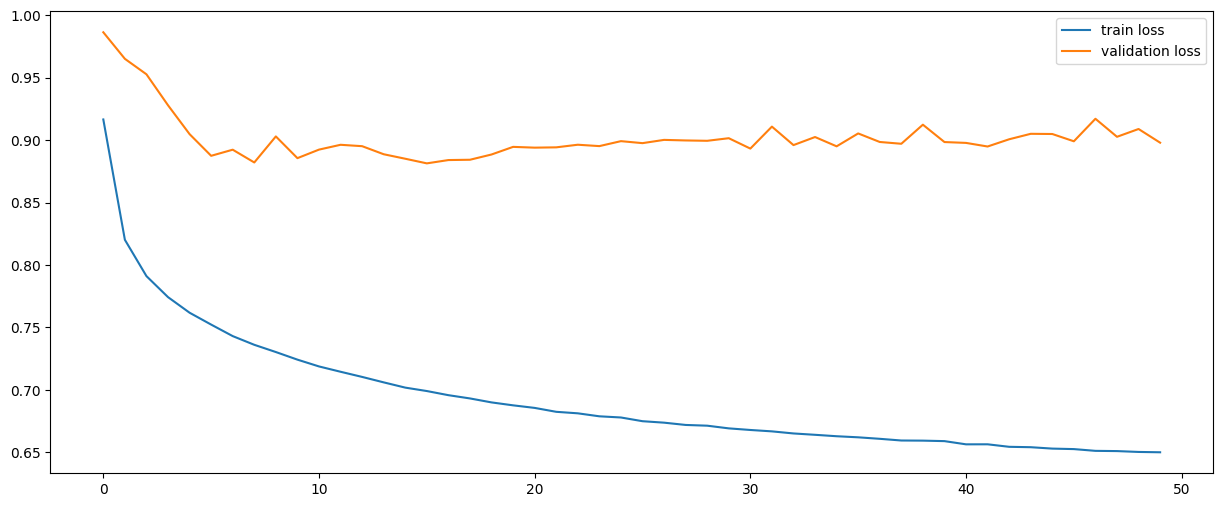

In [21]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

## Model_Testing

In [22]:
model = torch.load('../runs/my_best_val_model_pytorch')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

/var/folders/7c/fms9v7rj3w3_ssh2tnrr_0t00000gn/T/ipykernel_4634/3582570203.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('../runs/my_best_val_model_

Test acc: 0.7433


In [23]:
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)   

In [24]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.7432969144299151
              precision    recall  f1-score   support

           0     0.7010    0.7637    0.7310     47915
           1     0.8109    0.7430    0.7754     48050
           2     0.7256    0.7212    0.7234     43523

    accuracy                         0.7433    139488
   macro avg     0.7458    0.7426    0.7433    139488
weighted avg     0.7465    0.7433    0.7439    139488

